In [1]:
import sys
import os
sys.path.append('../..')
sys.path

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import tensorflow as tf
from phmd import datasets
import numpy as np
from phm_framework.data import meta
from phm_framework.nets.dpm  import DiffusionModel
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from phm_framework.nets import dpm 
from phm_framework.data import prepare_data
from phm_framework.data import synthetic
from tqdm import tqdm

2024-12-29 11:35:51.098309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735468551.112800   23594 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735468551.117142   23594 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-29 11:35:51.131371: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument 

In [3]:
meta_att = [f"att{i}" for i in range(10)]

dpm_model = dpm.DiffusionModel(128,
                     widths=[32, 64, 64, 32, 32, 32],
                     block_depth=3,
                     num_features=len(meta_att),
                     timesteps=20,
                     cond=True,
                     envelopes=True,
                     feature_names=meta_att,
                     feature_loss_net=False,
                     feature_loss=False)

dpm_model.network = tf.keras.models.load_model("../../../weights/JNUB_DPM_v1.h5",
                                         custom_objects = {"Gather": dpm.Gather,
                                                           "Swish": dpm.Swish})

I0000 00:00:1735426241.619044    3584 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10525 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [3]:
ds = datasets.Dataset("JNUB")
task = ds['fault']
sets = task[0]


X_train, M_train, Y_train = prepare_data(sets['train'], 'vibration', subsignal_length=128, signal_max_length=500500)
_mmin, _mmax = M_train.min(axis=0), M_train.max(axis=0)


X_val, M_val, Y_val = prepare_data(sets['val'], 'vibration', subsignal_length=128, signal_max_length=500500)


Dataset JNUB already downloaded and extracted
Remember to cite the original publisher dataset:
	@article{li2013sequential,
	  title={Sequential fuzzy diagnosis method for motor roller bearing in variable operating conditions based on vibration analysis},
	  author={Li, Ke and Ping, Xueliang and Wang, Huaqing and Chen, Peng and Cao, Yi},
	  journal={Sensors},
	  volume={13},
	  number={6},
	  pages={8013--8041},
	  year={2013},
	  publisher={Molecular Diversity Preservation International (MDPI)}
	}
	
You can download the dataset manually from:  https://github.com/ClarkGableWang/JNU-Bearing-Dataset

** If you find this tool useful, please cite our SoftwareX paper.



Reading : 100%|██████████| 12/12 [00:01<00:00, 11.02it/s]
INFO:root:Read in 1.2452595233917236 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: vibration,speed,fault,unit
INFO:root:Train shape: (3003000, 4)
INFO:root:Val shape: (3003000, 4)
INFO:root:Test shape: (3003000, 4)
INFO:root:Meta-attributes extracted in 17.861154556274414 seconds
INFO:root:Meta-attributes extracted in 17.81989860534668 seconds


In [5]:
ds.describe()

JNUB

Description
The dataset, provided by Jiangnan University (JNU), encompasses three sets of bearing vibration data distinguished by different rotating speeds, all sampled at a rate of 50 kHz. Each set comprises one healthy state and three distinct fault modes: inner ring fault, outer ring fault, and rolling element fault. Thus, the dataset encompasses a total of four classes, representing one healthy state and three fault modes. In total, there are 12 experimental units, with half corresponding to the healthy condition and the remaining units evenly distributed among the three fault conditions.

Designation: Jiangnan University bearing dataset
Publisher: Jiangnan University
Domain: Mechanical component
Application: Bearing
License: CC BY 3.0

System info
fault component    : bearing (LDK UER204)
platform           : A diagnostic test was conducted on a Mitsubishi SB-JR inductor motor used in a centrifugal fan system. The motor, a 3.7 kW three-phase induction motor, had specific nam

In [6]:
(X, E, M), (centroids, stds, kmeans) = synthetic.generate_synth_data(X_train, N=100000)    

/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


I0000 00:00:1735244116.049506   11246 cuda_dnn.cc:529] Loaded cuDNN version 90300


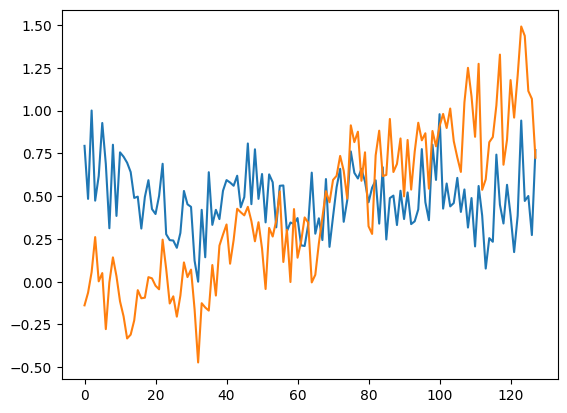

In [7]:
s = X_train[100]
f = synthetic.generate_meta(s, centroids)

f[-5] = 0.02

sn = synthetic.generate_synthetic_from_dpm(s, dpm_model, centroids, forced_features=np.array([f]))


plt.plot(s)
plt.plot(sn[0])

In [4]:
from phm_framework.nets import cnn
from importlib import reload
reload(cnn)

nclasses = len(np.unique(Y_train))
EPOCHS = 200

if os.path.exists('../../../weights/JNUB_fault_model.h5'):
        jnub_model = tf.keras.models.load_model("../../../weights/JNUB_fault_model.h5")
else:
    results, jnub_model = cnn.train((np.expand_dims(X_train, axis=-1), Y_train), 
                           nclasses, 
                           EPOCHS, 
                           es=False, 
                           validation_data=(np.expand_dims(X_val, axis=-1), Y_val))
    jnub_model.save('JNUB_fault_model.h5')

I0000 00:00:1735468593.716377   23594 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10525 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


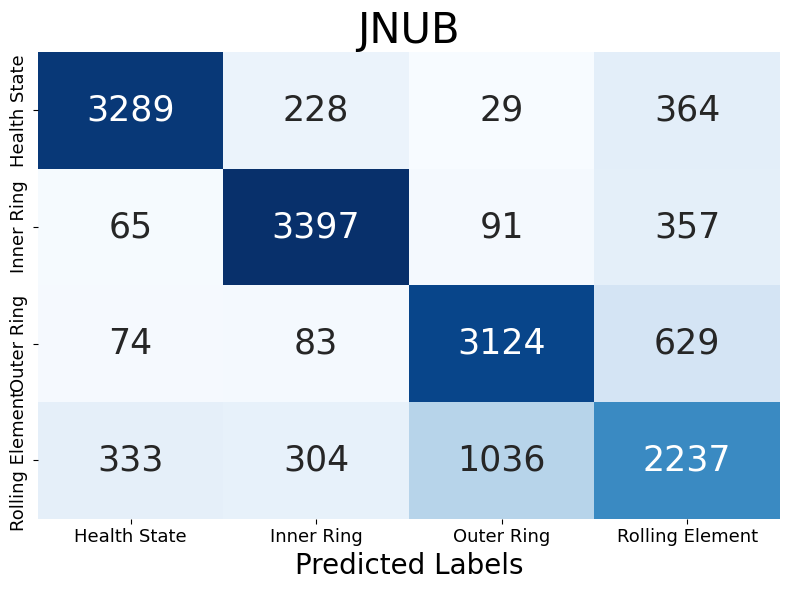

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model and get predictions
Y_pred = jnub_model.predict(X_val)
Y_pred_classes = Y_pred.argmax(axis=1)  # Get the predicted class index
Y_true = Y_val   # Get the true class index



# Compute confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Define class labels (replace with your actual class names)
class_labels = ["Health State", "Inner Ring", "Outer Ring", "Rolling Element"]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels,
           annot_kws={"size": 25}, cbar=False)
plt.xlabel('Predicted Labels', fontsize=20)
#plt.ylabel('True Labels', fontsize=20)
plt.title('JNUB', fontsize = 30)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.tight_layout()
plt.savefig('cm_jnub.pdf')

/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)


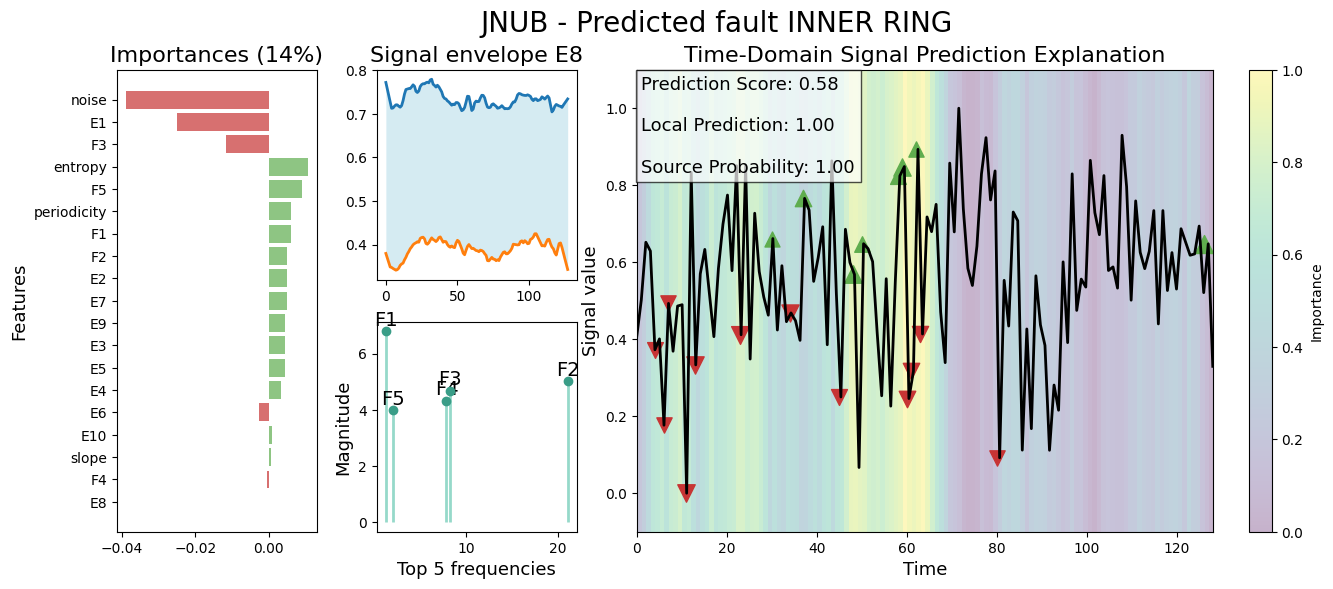

In [10]:
from phm_framework.xai import lime
from phm_framework.data import meta, synthetic
from phm_framework.xai import plot
from importlib import reload
reload(plot)

difflime = lime.DiffLIME(jnub_model, dpm_model, centroids, nsamples=100, verbose=False)

_, explanation, prediction_score, local_pred, source_prob, source_klass = difflime.explain(X_val[0])


plot.plot_importances(X_val[0], explanation, prediction_score, local_pred, 
                 source_prob, centroids, 
                      title=f"JNUB - Predicted fault {task.meta['target_labels'][source_klass].upper()}", 
                      topi=20, base_frec=50)

Generate explanations for the validation set:

In [ ]:
from phm_framework.xai import lime
from phm_framework.xai import plot

import pickle as pk
import tqdm
import gc

indexes = np.arange(0, X_val.shape[0])
np.random.shuffle(indexes)

for i in tqdm.tqdm(indexes):
    try:
        difflime = lime.DiffLIME(jnub_model, dpm_model, centroids, nsamples=200, verbose=False)
        (_, explanation, prediction_score, local_pred, source_prob, source_klass) = difflime.explain(X_val[i])
        plot.plot_importances(X_val[i], explanation, prediction_score, local_pred, 
                         source_prob, centroids, 
                         title=f"JNUB - Predicted fault {task.meta['target_labels'][source_klass]}", 
                         topi=20)
        plt.savefig(f"JNUB/S{i}_k{int(Y_val[i][0])}_p{source_klass}.svg")
        plt.savefig(f"JNUB/S{i}_k{int(Y_val[i][0])}_p{source_klass}.png")
        plt.cla()
        exp =(explanation, prediction_score, local_pred,  source_prob, source_klass)
        file = open(f"JNUB/S{i}_k{int(Y_val[i][0])}_p{source_klass}.pk", "wb")
        pk.dump(exp, file)   
        file.close()
        del difflime
        gc.collect()
    except:
        pass

  0%|          | 0/15640 [00:00<?, ?it/s]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  0%|          | 1/15640 [00:08<39:01:38,  8.98s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/

  0%|          | 13/15640 [01:02<18:30:59,  4.27s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  0%|          | 14/15640 [01:07<18:43:16,  4.31s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper r

  0%|          | 25/15640 [01:52<17:39:16,  4.07s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  0%|          | 26/15640 [01:57<18:46:57,  4.33s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper r

  0%|          | 38/15640 [02:50<18:41:17,  4.31s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  0%|          | 39/15640 [02:54<18:32:26,  4.28s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper r

  0%|          | 51/15640 [03:49<20:33:05,  4.75s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  0%|          | 52/15640 [03:53<19:56:09,  4.60s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper r

  0%|          | 64/15640 [04:47<18:30:40,  4.28s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  0%|          | 65/15640 [04:52<19:31:28,  4.51s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper r

  0%|          | 77/15640 [05:48<19:36:21,  4.54s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  0%|          | 78/15640 [05:53<19:47:07,  4.58s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper r

  1%|          | 90/15640 [06:51<20:39:19,  4.78s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 91/15640 [06:55<19:48:30,  4.59s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper r

  1%|          | 103/15640 [07:52<20:39:00,  4.78s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 104/15640 [07:56<20:00:40,  4.64s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  1%|          | 116/15640 [08:52<20:32:09,  4.76s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 117/15640 [08:57<20:52:44,  4.84s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  1%|          | 129/15640 [09:52<20:15:01,  4.70s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 130/15640 [09:58<20:53:32,  4.85s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  1%|          | 142/15640 [10:53<20:58:15,  4.87s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 143/15640 [10:56<18:59:34,  4.41s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  1%|          | 155/15640 [11:53<19:56:16,  4.64s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 156/15640 [11:57<19:21:52,  4.50s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  1%|          | 168/15640 [12:55<20:44:10,  4.82s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 169/15640 [13:00<21:10:12,  4.93s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  1%|          | 181/15640 [13:59<21:38:28,  5.04s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 182/15640 [14:04<21:46:13,  5.07s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  1%|          | 194/15640 [15:00<19:22:18,  4.51s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|          | 195/15640 [15:06<20:57:39,  4.89s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  1%|▏         | 207/15640 [16:05<21:39:14,  5.05s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|▏         | 208/15640 [16:10<21:12:30,  4.95s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  1%|▏         | 220/15640 [17:05<21:05:43,  4.93s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|▏         | 221/15640 [17:10<21:15:42,  4.96s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  1%|▏         | 233/15640 [18:08<21:08:05,  4.94s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  1%|▏         | 234/15640 [18:13<21:18:25,  4.98s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 246/15640 [19:11<19:59:39,  4.68s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 247/15640 [19:16<21:10:56,  4.95s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 259/15640 [20:16<22:08:31,  5.18s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 260/15640 [20:21<21:54:23,  5.13s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 272/15640 [21:22<21:33:19,  5.05s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 273/15640 [21:27<21:22:15,  5.01s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 285/15640 [22:26<20:26:57,  4.79s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 286/15640 [22:31<21:01:59,  4.93s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 298/15640 [23:34<21:48:53,  5.12s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 299/15640 [23:39<21:36:45,  5.07s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 311/15640 [24:42<22:50:23,  5.36s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 312/15640 [24:48<22:36:08,  5.31s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 324/15640 [25:47<22:04:06,  5.19s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 325/15640 [25:52<21:24:27,  5.03s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 337/15640 [26:53<22:28:40,  5.29s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 338/15640 [26:58<22:35:54,  5.32s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 350/15640 [28:02<22:33:31,  5.31s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 351/15640 [28:08<23:24:05,  5.51s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 363/15640 [29:10<22:49:03,  5.38s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 364/15640 [29:15<22:41:56,  5.35s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 376/15640 [30:18<22:29:55,  5.31s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 377/15640 [30:24<23:36:38,  5.57s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  2%|▏         | 389/15640 [31:30<23:41:53,  5.59s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  2%|▏         | 390/15640 [31:35<23:22:34,  5.52s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 402/15640 [32:41<22:29:24,  5.31s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 403/15640 [32:45<21:06:14,  4.99s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 415/15640 [33:51<24:01:01,  5.68s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 416/15640 [33:57<24:17:43,  5.75s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 428/15640 [35:04<24:15:10,  5.74s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 429/15640 [35:10<23:52:02,  5.65s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 441/15640 [36:17<23:21:30,  5.53s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 442/15640 [36:23<23:51:57,  5.65s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 454/15640 [37:30<22:45:18,  5.39s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 455/15640 [37:36<23:49:08,  5.65s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 467/15640 [38:44<24:38:42,  5.85s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 468/15640 [38:50<24:47:57,  5.88s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 480/15640 [39:57<24:19:58,  5.78s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 481/15640 [40:03<24:06:54,  5.73s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 493/15640 [41:10<23:49:45,  5.66s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 494/15640 [41:15<22:07:53,  5.26s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 506/15640 [42:22<23:42:13,  5.64s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 507/15640 [42:27<23:13:38,  5.53s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 519/15640 [43:37<24:02:49,  5.73s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 520/15640 [43:43<24:09:55,  5.75s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 532/15640 [44:54<25:12:20,  6.01s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 533/15640 [44:59<24:35:33,  5.86s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  3%|▎         | 545/15640 [46:07<23:35:04,  5.62s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  3%|▎         | 546/15640 [46:14<25:10:39,  6.00s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  4%|▎         | 558/15640 [47:25<25:13:32,  6.02s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  4%|▎         | 559/15640 [47:30<24:30:47,  5.85s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  4%|▎         | 571/15640 [48:40<24:22:50,  5.82s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
  4%|▎         | 572/15640 [48:45<24:11:27,  5.78s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper

  4%|▎         | 584/15640 [49:56<25:00:44,  5.98s/it]/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/home/dasolma/papers/diffLIME/src/phm_framework/notebooks/../../phm_framework/xai/plot.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)


/tmp/ipykernel_9792/2581339872.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


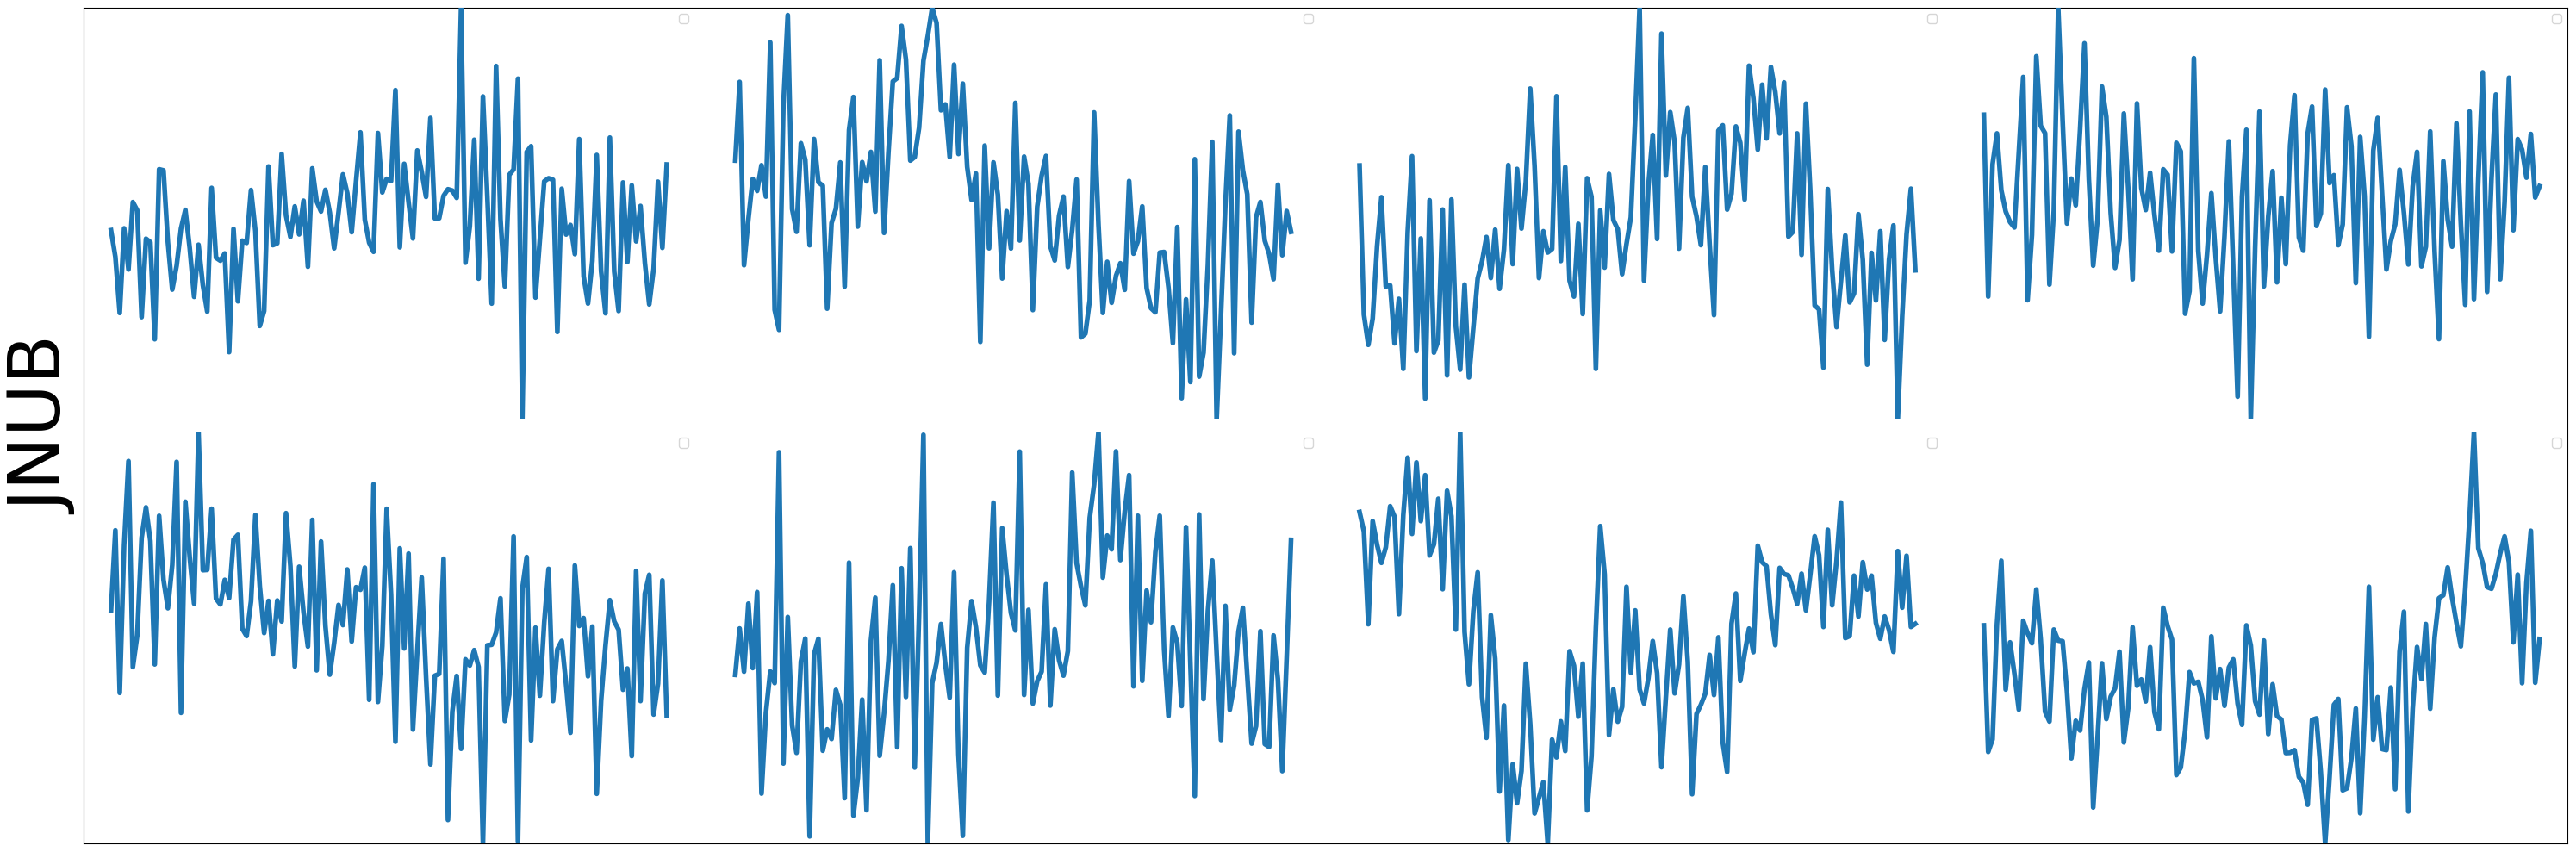

In [74]:
def plot_signals(series_temporales, labels):
    """
    Dibuja los clusters con una cuadrícula de 3 columnas y N filas.

    Args:
        series_temporales (numpy.ndarray): Array de series temporales.
        labels (numpy.ndarray): Etiquetas de los clusters.
        centroids (numpy.ndarray): Centroides de los clusters.
        n_clusters (int): Número de clusters.
    """
    # Determinar el número de filas y columnas
    n_cols = 4
    n_rows = int(np.ceil(series_temporales.shape[0] / n_cols))

    fig = plt.figure(figsize=(30, n_rows * 5))  # Ajustar tamaño según filas

    plt.xticks([], [])
    plt.yticks([], [])
    plt.ylabel("JNUB", fontsize=60)
    
    for index,(s, label) in enumerate(zip(series_temporales, labels)):
        ax = plt.subplot(n_rows, n_cols, index+1)  # Configurar subplot
        
        #if index < n_cols:
        #    ax.set_title(' '.join([l.capitalize() for l in label.split()]), fontsize=40)
        ax.plot(s, linewidth=4)
        
        #plt.title(f"Cluster {cluster_idx}")
        ax.set_ylim(0, 1)
        ax.legend(loc="upper right")
        ax.set_axis_off()
        #plt.grid(True)

    plt.tight_layout()
    

signals = []
labels = []
for _ in range(2):
    for l in np.unique(Y_val):
        i = np.random.choice(np.where(Y_val == l)[0])
        signals.append(X_val[i])
        labels.append(task.meta['target_labels'][int(l)])
    
plot_signals(np.array(signals), labels)
plt.savefig('JNUB_samples.pdf')